In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import torch
import random
from PIL import Image
from dataset.preprocessing import sample_pixels, segmap_to_binary, binary_to_image
import torchvision.transforms as transforms

# Import the UNet class
from model.my_unet_model import UNet


In [5]:
# Specify the device
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
if torch.backends.mps.is_available():
    device = 'mps'

# Load the model and map it to the GPU
model = torch.load("saved_models/model_full.pth", map_location=device)

# Set the model to evaluation mode
model.eval()

print("Model loaded onto", device)

Model loaded onto mps


/var/folders/5m/5hqxry713v946xwvr21xjx180000gn/T/ipykernel_6403/1102944717.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("saved_models/model_full_ol

(224, 224)
torch.Size([1, 1, 224, 224])


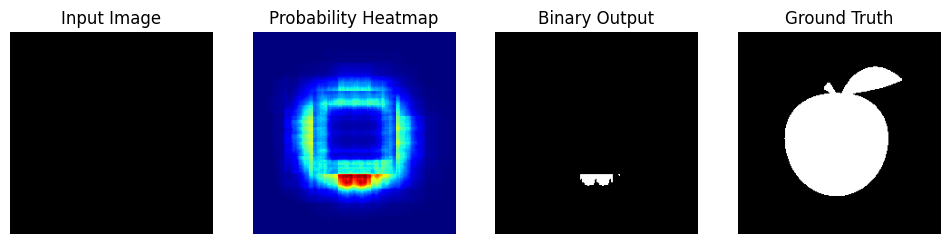

Loss: 0.5162199139595032


In [6]:
# Load the test image
image_path = r"../data_new/176.png"
image = Image.open(image_path).convert('L')
image = np.array(image)
image = np.zeros_like(image)
target_image_path = r"../data_new/176.png"
target_image = Image.open(target_image_path).convert('L')
target_image = np.array(target_image)
print(target_image.shape)
input = transforms.ToTensor()(image).unsqueeze(0).to(device)



# Assuming the model is defined and loaded
model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates)
with torch.no_grad():  # Disable gradient calculation for evaluation
    y = model(input)  # Get the model's predictions

print(y.shape)

y_image = y[0][0].cpu().numpy()
binary_output = (y_image > 0.5).astype(np.uint8)
#show image, probability heatmap and ground truth
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(y_image, cmap='jet')
plt.title('Probability Heatmap')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(binary_output, cmap='gray')
plt.title('Binary Output')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(target_image, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')
plt.show()

#Calculate loss
loss = torch.nn.BCELoss()
target = transforms.ToTensor()(target_image).unsqueeze(0).to(device)
loss_value = loss(y, target)
print('Loss:', loss_value.item())



Model loaded onto cuda


C:\Users\iacop\AppData\Local\Temp\ipykernel_15964\1795345592.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("saved_models/model_full.pth", map_locat

torch.Size([1, 1, 224, 224])


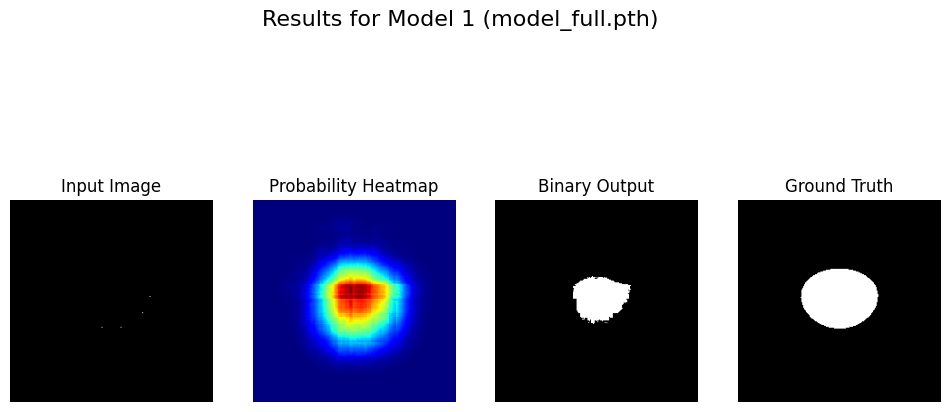

Loss: 0.09596443176269531
Model loaded onto cuda


C:\Users\iacop\AppData\Local\Temp\ipykernel_15964\1795345592.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("saved_models/best_model_focal_loss

torch.Size([1, 1, 224, 224])


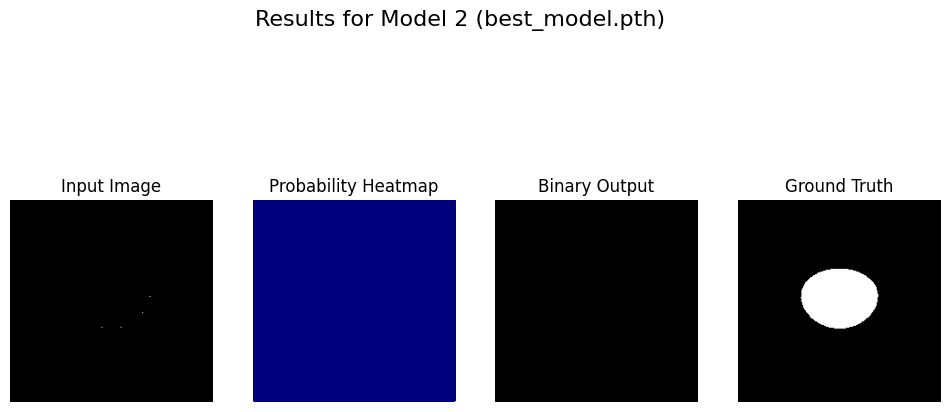

Loss: 8.789064407348633


In [31]:
# Load the test image
randimage = random.randint(1,2500)
num_image = str(randimage)

randsample = random.randint(0,399)



base_path = r"./data/"

image_path = os.path.join(base_path, 'samples')
image_path= os.path.join(image_path, num_image)
image_path = os.path.join(image_path, f"{randsample}.png")

image = Image.open(image_path).convert('L')
image = np.array(image)
target_image_path = os.path.join(base_path, f"{randimage}.png")
target_image = Image.open(target_image_path).convert('L')
target_image = np.array(target_image)
input = transforms.ToTensor()(image).unsqueeze(0).to(device)


# Load the model and map it to the GPU model1
model = torch.load("saved_models/model_full.pth", map_location=device)


# Set the model to evaluation mode
model.eval()

print("Model loaded onto", device)

# Assuming the model is defined and loaded
model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates)
with torch.no_grad():  # Disable gradient calculation for evaluation
    y = model(input)  # Get the model's predictions

print(y.shape)

y_image = y[0][0].cpu().numpy()
binary_output = (y_image > 0.5).astype(np.uint8)
#show image, probability heatmap and ground truth
plt.figure(figsize=(12, 6))
plt.suptitle("Results for Model 1 (model_full.pth)", fontsize=16)
plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(y_image, cmap='jet')
plt.title('Probability Heatmap')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(binary_output, cmap='gray')
plt.title('Binary Output')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(target_image, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')
plt.show()

#Calculate loss
loss = torch.nn.BCELoss()
target = transforms.ToTensor()(target_image).unsqueeze(0).to(device)
loss_value = loss(y, target)
print('Loss:', loss_value.item())

##############################
# Load the saved model checkpoint
checkpoint = torch.load("saved_models/best_model_focal_loss.pth", map_location=device)
model = checkpoint['model_state_dict']
# Initialize the UNet model with the appropriate parameters
#model = UNet(1, 32, 1)

# Load the state dictionary for the model from the checkpoint
#model.load_state_dict(checkpoint['model_state_dict'])


# Map the model to the appropriate device (GPU or CPU)
model.to(device)


# Set the model to evaluation mode
model.eval()

print("Model loaded onto", device)

# Assuming the model is defined and loaded
model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates)
with torch.no_grad():  # Disable gradient calculation for evaluation
    y = model(input)  # Get the model's predictions

print(y.shape)

y_image = y[0][0].cpu().numpy()
binary_output = (y_image > 0.5).astype(np.uint8)
#show image, probability heatmap and ground truth
plt.figure(figsize=(12, 6))
plt.suptitle("Results for Model 2 (best_model.pth)", fontsize=16)
plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(y_image, cmap='jet')
plt.title('Probability Heatmap')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(binary_output, cmap='gray')
plt.title('Binary Output')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(target_image, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')
plt.show()

#Calculate loss
loss = torch.nn.BCELoss()
target = transforms.ToTensor()(target_image).unsqueeze(0).to(device)
loss_value = loss(y, target)
print('Loss:', loss_value.item())

In [35]:
from stable_baselines3 import PPO

# Load the saved PPO model
model = PPO.load("C:/Users/iacop/OneDrive - TUM/Desktop/Programmazione/Github/tum-adlr-11/PPO_150.zip")

In [36]:
import gymnasium as gym
import sys
import os
import torch

from stable_baselines3.common.monitor import Monitor
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
from torchvision import transforms
from torchvision.transforms import ToTensor

# Add the path to the 'model' folder (or wherever your 'my_unet_model.py' is located)
# Use the current working directory to get the model folder
sys.path.append(os.path.join(os.getcwd(), 'dataset'))
sys.path.append(os.path.join(os.getcwd(),'reinforcment_learning'))


from reinforcment_learning.enviroment import RayEnviroment 
from dataset.create_dataset_file import ImageDataset


# Specify the device
device = 'cpu'


# Load the model and map it to the GPU
unet = torch.load("C:/Users/iacop/OneDrive - TUM/Desktop/Programmazione/Github/tum-adlr-11/2D_Shape_Completion/saved_models/model_full.pth", map_location=device)


# Set the model to evaluation mode
unet.eval()

print("Model loaded onto", device)

# Step 3: Reload Dataset and DataLoader with the Updated Transform
dataset = ImageDataset('C:/Users/iacop/OneDrive - TUM/Desktop/Programmazione/Github/tum-adlr-11/2D_Shape_Completion/data', num_samples=100, len_dataset=10, transform=transforms.Compose([ToTensor()]))
print(len(dataset))

training_period=1
image_shape = (224,224)
env = RayEnviroment(image_shape,
    model=unet,
    loss = torch.nn.BCELoss(), 
    max_number_rays = 15,
    dataset=dataset, 
    device=device, 
    render_mode='rgb_array',
    ) 
    
# Required for video recording)
env = RecordVideo(env, video_folder="inference_video", name_prefix="Inference",
                  episode_trigger=lambda x: x % training_period == 0)

Model loaded onto cpu
900


C:\Users\iacop\AppData\Local\Temp\ipykernel_15964\3300694863.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet = torch.load("C:/Users/iacop/OneDrive - TUM/Desktop/Pr

In [37]:
# Reset the environment to start a new episode
# Number of episodes you want to run
num_episodes = 5

# Run the specified number of episodes
for episode in range(num_episodes):
    obs, info = env.reset()  # Reset the environment at the start of each episode
    done = False
    total_reward = 0  # Variable to track the total reward for the episode

    # Run the episode
    while not done:
        # Get the action predicted by the model
        action, _states = model.predict(obs)

        # Take the action in the environment and get the results
        obs, reward, done, truncated, info = env.step(action)
        
        # Update the total reward for this episode
        total_reward += reward
        
        # Optional: Render the environment to see it visually
        env.render()

    # Print the total reward for the current episode
    print(f"Episode {episode + 1} - Total Reward: {total_reward}")

# Close the environment after all episodes are complete
env.close()

Not found anything at iteration _0
Episode 1 - Total Reward: -2
Not found anything at iteration _0
Episode 2 - Total Reward: -2
Not found anything at iteration _0
Episode 3 - Total Reward: -2
Not found anything at iteration _0
Episode 4 - Total Reward: -2
Not found anything at iteration _0
Episode 5 - Total Reward: -2
